In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer


### Question 2: Applied ML
first, we load the 20 Newsgroup data set from sklearn library. This data set contains about 18000 newsgroup post on 20 topics. There is already a tarin and test split in the original data set which can be selected by picking the `subset` attribute as train or test. However, here we choose to load the whole data set and then we split it manually for trani and test data.

It is important to remove the `headers`, `footers`, `quotes` from the data set in order to have more realistic results. The reason is that it is easy for a classifier to overfit on particular things that appear in the 20 Newsgroups data, such as newsgroup headers. Therefore, without removing these parts our classifier would not be generalized enough.

In [6]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))

here we see a list of 20 topics contained in the 20 Newsgroup dataset.

In [7]:
print(list(newsgroups.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Next, we ecompute the Tf-Idf features for every article using <a href=http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.get_feature_names>TfidfVectorizer</a>. The output of this function is a matrix with number of rows equal to the number of articles and the number of columns equal to the whole number of terms found in the data set. We also choose to remove the stop words when compuring the Tf-Idf matrix. Stop words are words which are useless for the classification task, i.e. words which can appear in any document regardless of its topic for example: the, for, from, at, etc.

Below we can see that TfidfVectorizer has found 134101 different terms in the whole corpus.

In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape

(18846, 134101)

In [9]:
classes = newsgroups.target
classes.shape

(18846,)

Originally, the output of the `fetch_20newsgroups` is a dictionary with 6 keys. We mostly work with the data which contains the textual content of each post and also target_names which contains the class names.

In [10]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

As expected, the Tf-Idf matrix is a sparse matrix since each post contains only a subset of all terms. Below you can see that we have around 65 zeros for each post on average.

In [11]:
print('total number of zeros:', vectors.nnz)
print('{} average zero per data sample'.format(vectors.nnz / float(vectors.shape[0])))

total number of zeros: 1229435
65.23585906823729 average zero per data sample


We, split our data as 10% test data and 90% training data. First of all we shuffle the indices and then we split the data in order to avoid having any biases because of the time of the documents, their topic, etc.

In [12]:
ratio = 0.1
indices = np.random.permutation(vectors.shape[0])
split1 = int(np.floor(ratio*vectors.shape[0]))
test_vectors = vectors[indices[:split1]]
train_vectors = vectors[indices[split1:]]

In [13]:
test_classes = classes[indices[:split1]]
train_classes = classes[indices[split1:]]

We make a list of all terms contained in the corpus. We can see that even after removing stop words still the first 5 terms (sorted alphabetically) are some meaningless numbers.

In [55]:
feature_names = vectorizer.get_feature_names()
feature_names[:5]

['00', '000', '0000', '00000', '000000']

In [16]:
from sklearn.ensemble import RandomForestClassifier

Now we train a simple random forest classifier with the default parameters on the training data and compute its accuracy on test data.

In [17]:
RFclassifier = RandomForestClassifier()
RFclassifier.fit(train_vectors,train_classes)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
test_res = RFclassifier.predict(test_vectors)

We can see that the accuracy on test data is fairly low.

In [19]:
accuracy = np.mean([test_res[i]==test_classes[i] for i in range(len(test_classes))])
print('accuracy = {}%'.format(accuracy))

accuracy = 0.5567940552016986%


Now we try to fine tune the parameters `n_estimsators` and `max_depth` of random forest. The first parameter is the number of trees in the random forest and the second one is that he maximum depth of each tree in random forest. As high values of max_depth parameter leads to significant increase in the execution time of training, we first made a grid search with coarse intervals of max_depth (we removed the results of this part unfortunately) and then we reduced the range of max_depth parameter but with finer intervals.

In [113]:
from sklearn.model_selection import GridSearchCV, cross_val_score
n_estimator = [i for i in range(100,500,100)]
max_depth = [i for i in range(70,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1)
clf.fit(train_vectors,train_classes)

Next we make a pandas data frame from the results of grid search cross-validation. We sort the row by the rank of test score (the mean test score on the fold left out for validation). We can see that we get the best result for a maximum depth of 90 and 400 number of trees (both maximum values in the chosen intervals). This leads us to increase the number of trees even more to get better accuracy.

In [80]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)

In [82]:
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,193.704068,1.861396,0.665959,0.930019,90,400,"{'max_depth': 90, 'n_estimators': 400}",1,0.670081,0.929204,0.667787,0.928552,0.659996,0.932302,8.582209,0.063540,0.004315,0.001636
10,164.356243,1.463070,0.664367,0.928987,90,300,"{'max_depth': 90, 'n_estimators': 300}",2,0.666196,0.927522,0.667433,0.926607,0.659465,0.932833,3.241109,0.011763,0.003500,0.002745
7,192.822175,1.914934,0.663896,0.923003,80,400,"{'max_depth': 80, 'n_estimators': 400}",3,0.661957,0.921858,0.667079,0.920594,0.662653,0.926558,4.649892,0.012043,0.002269,0.002566
6,144.726100,1.384768,0.663188,0.921588,80,300,"{'max_depth': 80, 'n_estimators': 300}",4,0.667079,0.920000,0.666372,0.920064,0.656101,0.924702,4.070652,0.030675,0.005015,0.002202
3,185.075461,1.976391,0.661950,0.912569,70,400,"{'max_depth': 70, 'n_estimators': 400}",5,0.664430,0.911947,0.661596,0.909895,0.659819,0.915864,1.029161,0.081186,0.001899,0.002476


However, having a large number of trees each have relatively a large maximum depth would cause huge execution times. Therefore, we decided to keep the maximum depth small and rather grow the number of trees.

In [114]:
from sklearn.model_selection import GridSearchCV, cross_val_score
n_estimator = [i for i in range(900,1500,100)]
max_depth = [i for i in range(15,25,5)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},n_jobs=-1,cv=10)
clf.fit(train_vectors,train_classes)

In [24]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score',inplace=True)

The data frame below shows the results for 10 fold cross validation. As we can see the best score is significatly lower than previous best result. So it seems that max_depth parameter have more significat effect on the accuracy.

In [29]:
df.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,206.403024,2.846908,0.627815,0.735801,20,1400,"{'max_depth': 20, 'n_estimators': 1400}",1,0.626831,0.736021,...,0.624113,0.736804,0.626257,0.737738,0.629739,0.734909,5.851897,0.656986,0.005390,0.001231
6,258.454027,5.016123,0.627167,0.734825,20,900,"{'max_depth': 20, 'n_estimators': 900}",2,0.629760,0.733727,...,0.617021,0.735036,0.619752,0.732434,0.636848,0.737070,124.671179,4.633514,0.008866,0.001725
8,172.650512,2.227015,0.626990,0.736090,20,1100,"{'max_depth': 20, 'n_estimators': 1100}",3,0.632689,0.734448,...,0.617612,0.736477,0.623300,0.735774,0.638033,0.735564,6.941250,0.413777,0.006558,0.001622
9,175.958252,2.087759,0.626695,0.735500,20,1200,"{'max_depth': 20, 'n_estimators': 1200}",4,0.627417,0.735169,...,0.619976,0.737590,0.625074,0.733547,0.632109,0.733665,2.792028,0.224548,0.007453,0.001770
10,191.684709,2.696582,0.626223,0.735048,20,1300,"{'max_depth': 20, 'n_estimators': 1300}",5,0.637376,0.734907,...,0.615248,0.738441,0.627439,0.735512,0.633886,0.735367,4.519714,0.630316,0.009602,0.001854
7,271.482889,2.253534,0.623747,0.734131,20,1000,"{'max_depth': 20, 'n_estimators': 1000}",6,0.623902,0.734513,...,0.616430,0.735560,0.620343,0.736232,0.638033,0.734058,184.672345,0.618140,0.007267,0.001235
5,198.187554,3.269956,0.617321,0.696564,15,1400,"{'max_depth': 15, 'n_estimators': 1400}",7,0.623316,0.695969,...,0.609338,0.695940,0.613247,0.697007,0.632109,0.695430,15.059122,0.926720,0.007486,0.001354
4,143.185758,3.339114,0.615552,0.695548,15,1300,"{'max_depth': 15, 'n_estimators': 1300}",8,0.622730,0.697607,...,0.605201,0.697708,0.615021,0.697335,0.626185,0.694383,8.400814,1.927593,0.009330,0.002290
2,126.310065,2.051716,0.614432,0.695672,15,1100,"{'max_depth': 15, 'n_estimators': 1100}",9,0.619801,0.693281,...,0.605201,0.698690,0.612064,0.697073,0.625000,0.696085,7.743560,0.841904,0.007274,0.001895
3,128.958863,1.648862,0.613489,0.695902,15,1200,"{'max_depth': 15, 'n_estimators': 1200}",10,0.619215,0.692822,...,0.606383,0.692993,0.605559,0.696418,0.618483,0.692484,2.607042,0.151737,0.008274,0.002231


FInally, for getting our bst results we do a cross validation with our best parameters max_depth=90 and n_estimators=1500. 

In [30]:
n_estimator = [i for i in range(1500,1600,100)]
max_depth = [i for i in range(90,100,10)]
clf = GridSearchCV(estimator=RFclassifier, param_grid={'n_estimators':n_estimator,'max_depth':max_depth},verbose=2,n_jobs=-1,cv=10)
clf.fit(train_vectors,train_classes)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.2min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.4min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.6min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=20.8min
[CV] max_depth=90, n_estimators=1500 .................................
[CV] .................. max_depth=90, n_estimators=1500, total=33.4min
[CV] max_depth=9

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 75.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1500], 'max_depth': [90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [31]:
df1 = pd.DataFrame(clf.cv_results_)
df1.sort_values('rank_test_score',inplace=True)

We can see that our best accuracy on test data is 67.8%. Compared to the first grid search we have almost tripled our n_estimators while keeping max_depth the same, however the increase in the test score is not very significant given that the execution time was much higher for the latter parameter. This again shows that max_depth is more effective.

Apart from this, to get better scores much more preprocessing should be done on the textual data. For example as we showed above there were some all zeros terms in data which seemed meaningless for classification and probably should be removed. Also stemming and lemmatization will also help to both reduce the number of terms in Tf-Idf and increase the accuracy.

In [56]:
df1.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1515.116965,9.105797,0.678694,0.921884,90,1500,"{'max_depth': 90, 'n_estimators': 1500}",1,0.681898,0.919961,...,0.675532,0.921676,0.678888,0.920437,0.685427,0.922417,419.340684,3.010958,0.005734,0.001103


In [37]:
best_classifier = RandomForestClassifier(n_estimators=1500,max_depth=90,n_jobs=-1)
best_classifier.fit(train_vectors,train_classes)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

At the end we make a prediction on test data using our best classifier. We see that the accuracy is 67.5% as expected.

In [41]:
test_res = best_classifier.predict(test_vectors)

In [42]:
accuracy = np.mean([test_res[i]==test_classes[i] for i in range(len(test_classes))])
print('accuracy = {}%'.format(accuracy))

accuracy = 0.6756900212314225%


In [44]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_classes, test_res)

Finally we visualize the confusion matrix of our classifier (<a href=http://scikit-learn.org/0.15/auto_examples/model_selection/plot_confusion_matrix.html>Confusion matrix</a>). It shows that how many time a class was mislabelled by other classes.

Confusion matrix, without normalization


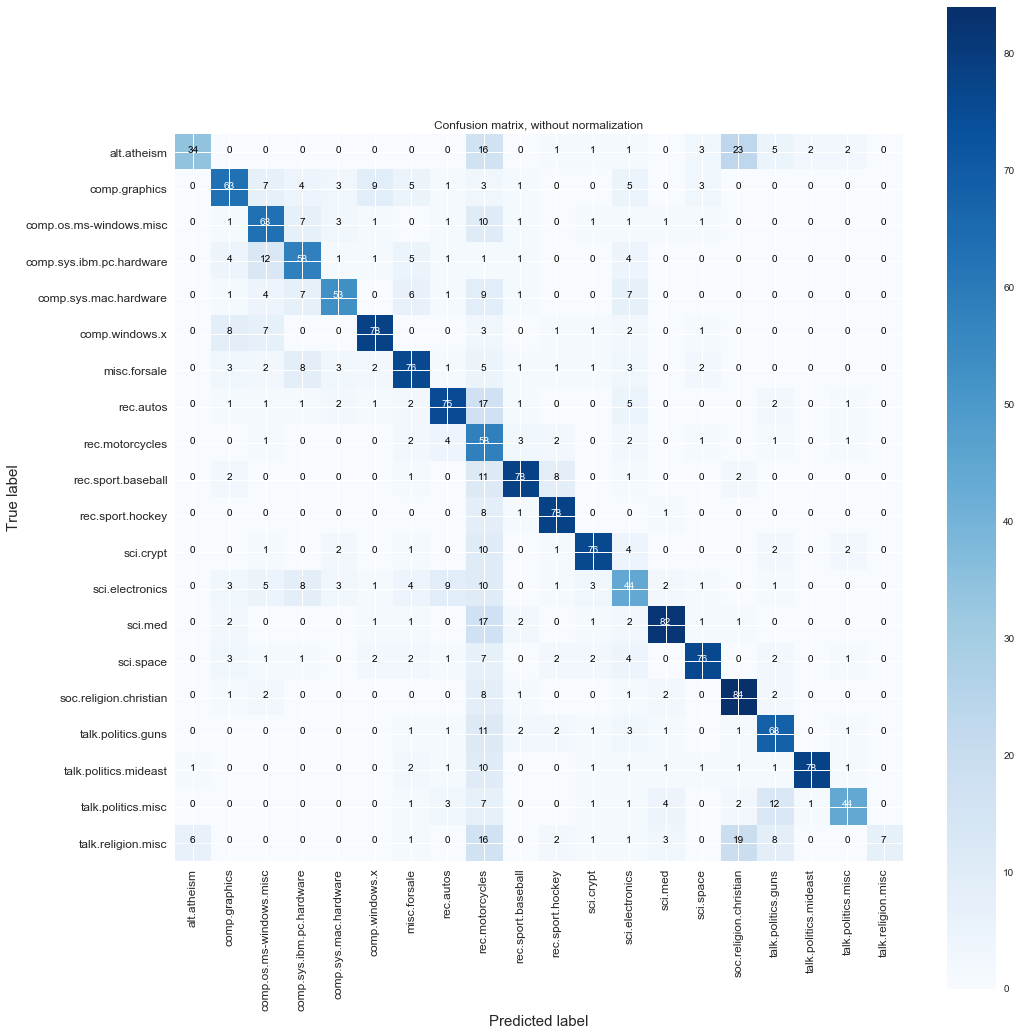

In [54]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')


In the above matrix we can see that in most of the cases, similar classes are mislabelled. For example _atheism_ is mislabelled 6 times with _religion_. We list below some other examples:
- _ms-windows_ has been mislabelled 12 times with _hardware_.
- _windows.x_ has benn mislabelled 9 times with _graphics_.
- _autos_ has been mislabelled 9 times with _electronics_ which makes sense somehow. maybe there were some post about electronic system of cars or electric cars.
- _christian_ has been mislabelled 23 times with _atheism_ and 19 times with _religion_.
- _guns_ has been mislabelled 12 times with _politics_.

The only wierd thing is about _motorcycles_ category which has been mislabelled with Quiet a lot of unrelated subjects. For example 16 times with _religion_ and 17 times with _atheism_ and 17 times with autos. It seems that smples in this class are contributing a lot to misclassifications.

Below we can see the top 10 most important terms in the corpus. We can easily find relationship between these words and categories. For example windows is probably related to _ms_windows_ and _windows.x_ class. 

In [43]:
importance = best_classifier.feature_importances_
sorted_indicies = np.argsort(importance)
sorted_indicies = sorted_indicies[::-1]
[feature_names[i] for i in sorted_indicies[:10]]

['windows',
 'bike',
 'car',
 'sale',
 'god',
 'space',
 'game',
 'israel',
 'clipper',
 'hockey']